In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.stats import entropy
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexMTLPytorchModel import ConvexMTLPytorchRegressor
from convexmtl_torch.model.GraphLaplacianMTLPytorchModel import GraphLaplacianMTLPytorchRegressor

from convexmtl_torch.model.utils import NeuralNetwork

from sklearn.model_selection import GridSearchCV

from convexmtl_torch.data.MTLSyntheticDataset import MTLClustersARegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.base import clone
import joblib
import os


from copy import copy

from utils import train_gs

import random


In [2]:
max_epochs=50
log_every_n_steps=10
problem = 'common'

In [3]:
seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [4]:
mtlds = MTLClustersARegression(n_samples_per_task=50)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

Init Synth


ic| tasks: [0, 10, 11, 12, 13, 20]


TASK FUNCTIONS


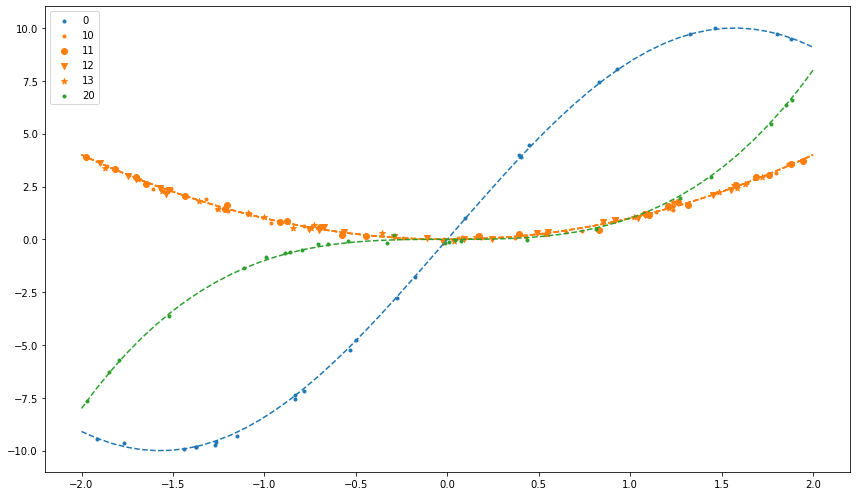

In [6]:
mtlds.plot_data_functions(X, y)
plt.tight_layout()
plt.savefig('clustersA.pdf')


ic| rg_idx: array([0])
ic| rg_idx: array([1, 2, 3, 4])
ic| rg_idx: array([5])


<AxesSubplot:>

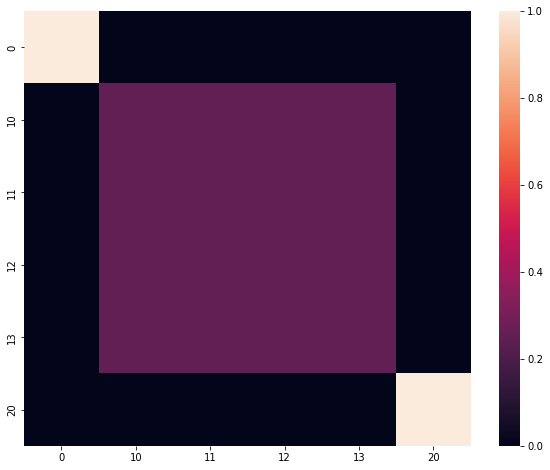

In [6]:
mtlds.plot_adj_matrix()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [8]:
X_train.shape

(100, 2)

## ConvexMTL Torch

In [9]:
model = GraphLaplacianMTLPytorchRegressor(adj_trainable=True, train_mode='numpy', epochs=500, batch_size=32, val_size=0, early_stopping=True, patience=50, nu=0)
model

GraphLaplacianMTLPytorchRegressor(adj_trainable=True, batch_size=32, epochs=500,
                                  nu=0, patience=50, val_size=0)

In [10]:
wd_l = [10**(k) for k in range(-2, 1)]
lamblr_l = [10**(k) for k in range(-2, -1)]

params = {
    'weight_decay' : wd_l,
    # 'lambda_lr' : lamblr_l,
}
params

{'weight_decay': [0.01, 0.1, 1]}

In [11]:
# best = train_gs(model, params, X_train, y_train, model_name='convexmtlNN', problem_name=problem, scoring='neg_mean_squared_error', retrain=False)
best = model

In [12]:
best.fit(X_train, y_train)

ic| n_output: 1
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}
Loss:   0%|          | 0/500 [00:00<?, ?it/s]/home/carlos.ruizp/miniconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/core/module.py:416: UserWarning: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`
  rank_zero_warn(
Loss: 1.5333e-02, Tr:0.02(0.02), V:N/A: 100%|██████████| 500/500 [00:58<00:00,  8.61it/s] 


In [13]:
pred = best.predict(X_test)

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred, y_test)

0.03067478587948813

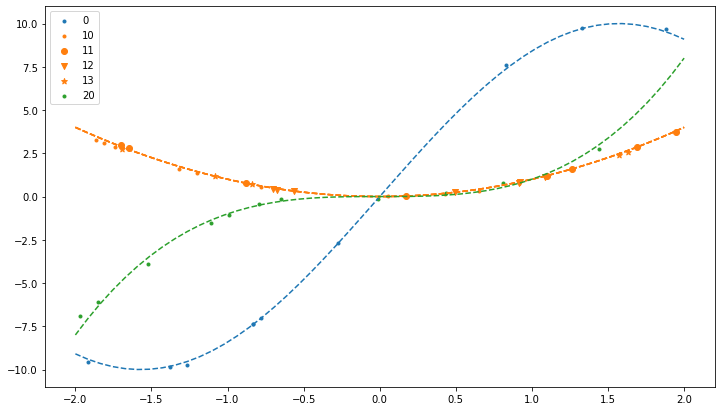

In [15]:
mtlds.plot_data_functions(X_test, pred)

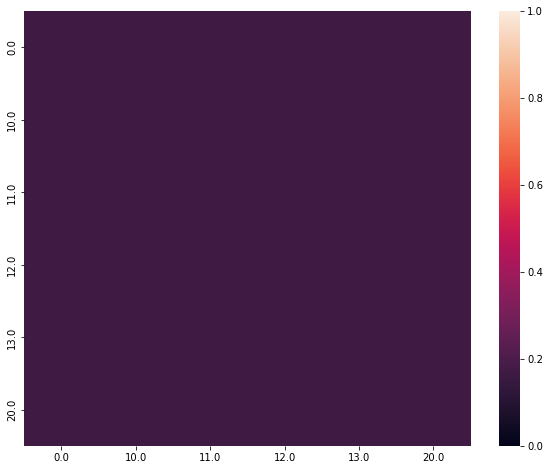

In [16]:
best.plot_adjmatrix()
plt.show()

In [17]:
nu_l = [10**k for k in range(-5, 1)]
mu_l = [10**k for k in range(-6, 0)]

X1, X2 = np.meshgrid(nu_l, mu_l)
ic(X1)
ic(X1.shape)

ic(X2.shape)

# Z = np.zeros((len(nu_l), len(mu_l)))
# for i in range(len(nu_l)):
#     for j in range(len(mu_l)):
#         mu = X1[i, j]
#         nu= X2[i, j]
#         Z[i, j] = nu + mu

ic| X1: array([[1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00],
               [1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]])
ic| X1.shape: (6, 6)
ic| X2.shape: (6, 6)


(6, 6)

In [18]:
def matrix_entropy(matrix):
    ent = 0
    num_rows = matrix.shape[0]
    for row in matrix:
        ent_r = entropy(row) / num_rows
        ent += ent_r

    return ent


In [19]:
model = GraphLaplacianMTLPytorchRegressor(adj_trainable=True, train_mode='numpy', epochs=30, batch_size=32, val_size=0, early_stopping=False)
model

GraphLaplacianMTLPytorchRegressor(adj_trainable=True, batch_size=32,
                                  early_stopping=False, epochs=30, val_size=0)

In [20]:


RESULTS_DIR = 'results'

real_matrix = mtlds.get_adj_matrix()

Z_dist = np.zeros((len(mu_l), len(nu_l)))
Z_train = np.zeros((len(mu_l), len(nu_l)))
Z_test = np.zeros((len(mu_l), len(nu_l)))
Z_ent = np.zeros((len(mu_l), len(nu_l)))
for i in range(len(mu_l)):
    for j in range(len(nu_l)):
        nu = X1[i, j]
        mu= X2[i, j]
        ic(nu, mu)
        filename_matrix = '{}/matrix_(nu={})_(mu={}).joblib'.format(RESULTS_DIR, np.log10(mu), np.log10(nu))
        if not os.path.exists(filename_matrix):
            model_ = clone(model)
            model_.set_params(mu=mu, nu=nu)
            model_.fit(X_train, y_train)
            pred_train = model_.predict(X_train)
            error_train = mean_squared_error(pred_train, y_train)
            pred_test = model_.predict(X_test)
            error_test = mean_squared_error(pred_test, y_test)

            adjmatrix = model_.get_adjmatrix()
            joblib.dump((adjmatrix, error_train, error_test), filename_matrix)
        else:
            adjmatrix, error_train, error_test = joblib.load(filename_matrix)
        
        dist = np.linalg.norm(adjmatrix - real_matrix)
        ent = matrix_entropy(adjmatrix)
        Z_dist[i, j] = dist
        Z_train[i, j] = error_train
        Z_test[i, j] = error_test
        Z_ent[i, j] = ent
        

ic| rg_idx: array([0])
ic| rg_idx: array([1, 2, 3, 4])
ic| rg_idx: array([5])
ic| nu: 1e-05, mu: 1e-06
ic| nu: 0.0001, mu: 1e-06
ic| nu: 0.001, mu: 1e-06
ic| nu: 0.01, mu: 1e-06
ic| nu: 0.1, mu: 1e-06
ic| nu: 1.0, mu: 1e-06
ic| nu: 1e-05, mu: 1e-05
ic| nu: 0.0001, mu: 1e-05
ic| nu: 0.001, mu: 1e-05
ic| nu: 0.01, mu: 1e-05
ic| nu: 0.1, mu: 1e-05
ic| nu: 1.0, mu: 1e-05
ic| nu: 1e-05, mu: 0.0001
ic| nu: 0.0001, mu: 0.0001
ic| nu: 0.001, mu: 0.0001
ic| nu: 0.01, mu: 0.0001
ic| nu: 0.1, mu: 0.0001
ic| nu: 1.0, mu: 0.0001
ic| nu: 1e-05, mu: 0.001
ic| nu: 0.0001, mu: 0.001
ic| nu: 0.001, mu: 0.001
ic| nu: 0.01, mu: 0.001
ic| nu: 0.1, mu: 0.001
ic| nu: 1.0, mu: 0.001
ic| nu: 1e-05, mu: 0.01
ic| nu: 0.0001, mu: 0.01
ic| nu: 0.001, mu: 0.01
ic| nu: 0.01, mu: 0.01
ic| nu: 0.1, mu: 0.01
ic| nu: 1.0, mu: 0.01
ic| nu: 1e-05, mu: 0.1
ic| nu: 0.0001, mu: 0.1
ic| nu: 0.001, mu: 0.1
ic| nu: 0.01, mu: 0.1
ic| nu: 0.1, mu: 0.1
ic| nu: 1.0, mu: 0.1


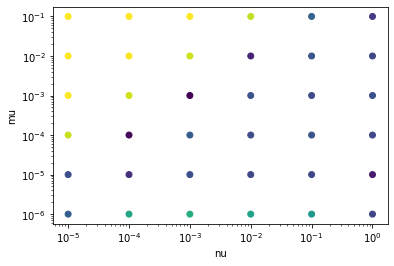

In [21]:
cm = plt.cm.get_cmap('viridis')
plt.scatter(X1, X2, c=Z_dist, cmap=cm)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.show()

ic| ent: 1.6221637252157073


<AxesSubplot:>

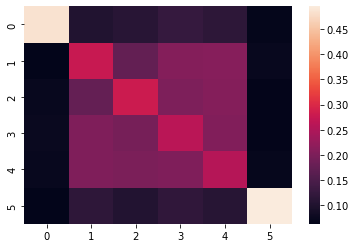

In [22]:
mu = 10**(-4)
nu = 10**(-4)

filename_matrix = '{}/matrix_(nu={})_(mu={}).joblib'.format(RESULTS_DIR, np.log10(mu), np.log10(nu))
adjmatrix, error_train, error_test = joblib.load(filename_matrix)

ent = matrix_entropy(adjmatrix)
ic(ent)

sns.heatmap(adjmatrix)

ic| ent: 1.7917594683132243


<AxesSubplot:>

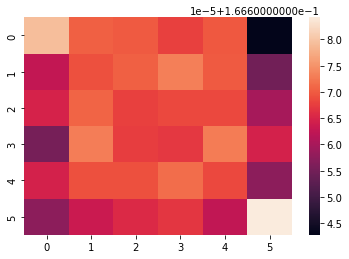

In [23]:
mu = 10**(-1)
nu = 10**(-5)

filename_matrix = '{}/matrix_(nu={})_(mu={}).joblib'.format(RESULTS_DIR, np.log10(mu), np.log10(nu))
adjmatrix, error_train, error_test = joblib.load(filename_matrix)

ent = matrix_entropy(adjmatrix)
ic(ent)

sns.heatmap(adjmatrix)

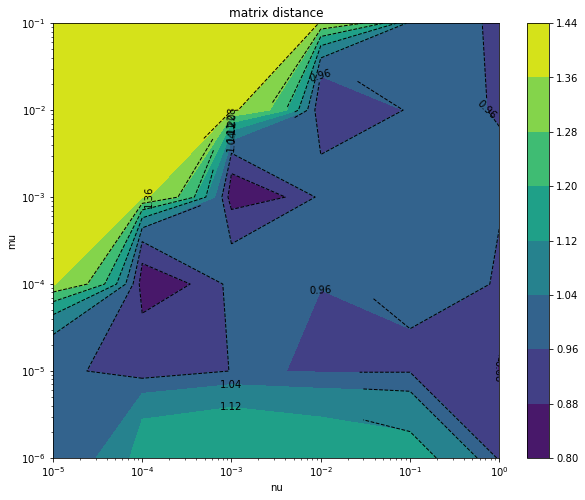

In [24]:
fig = plt.figure(figsize=(10, 8))
cp = plt.contour(X1, X2, Z_dist, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(X1, X2, Z_dist, )
cbar = fig.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('matrix distance')
plt.show()

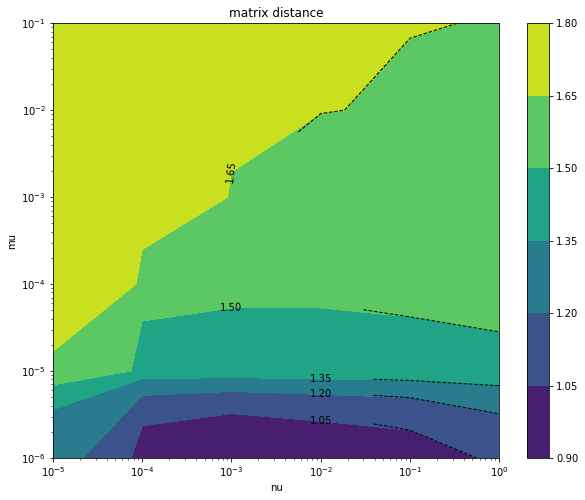

In [25]:
fig = plt.figure(figsize=(10, 8))
cp = plt.contour(X1, X2, Z_ent, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(X1, X2, Z_ent, )
cbar = fig.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('matrix distance')
plt.show()

ic| ent: 0.9203792609967587


<AxesSubplot:>

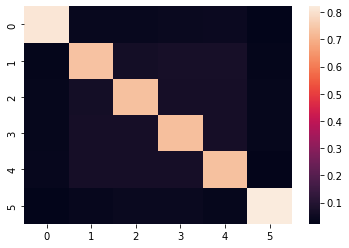

In [26]:
mu = 10**(-6)
nu = 10**(-3)

filename_matrix = '{}/matrix_(nu={})_(mu={}).joblib'.format(RESULTS_DIR, np.log10(mu), np.log10(nu))
adjmatrix, error_train, error_test = joblib.load(filename_matrix)

ent = matrix_entropy(adjmatrix)
ic(ent)

sns.heatmap(adjmatrix)

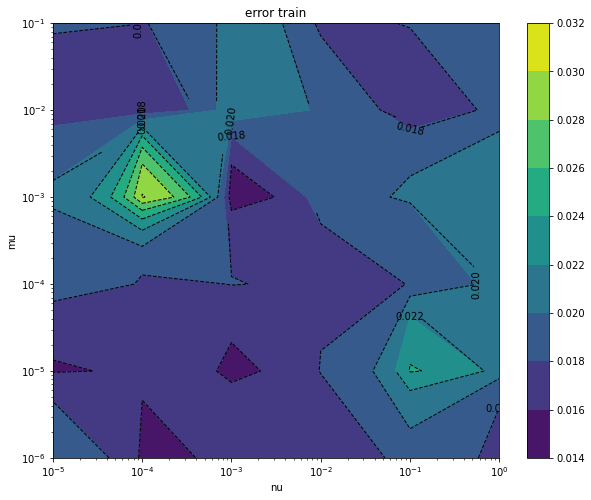

In [27]:
fig = plt.figure(figsize=(10, 8))
cp = plt.contour(X1, X2, Z_train, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(X1, X2, Z_train, )
cbar = fig.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('error train')
plt.show()

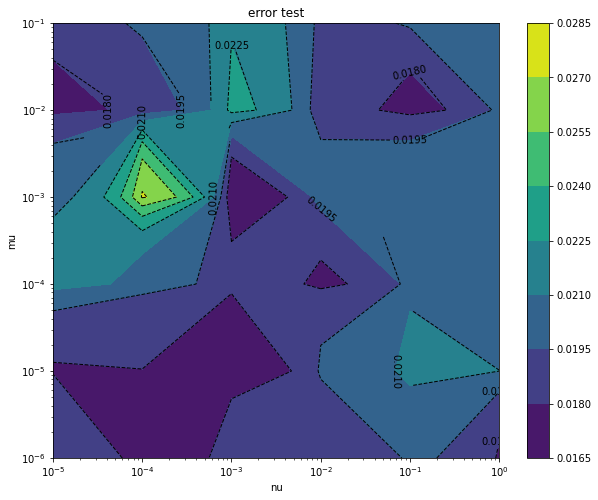

In [28]:
fig = plt.figure(figsize=(10, 8))
cp = plt.contour(X1, X2, Z_test, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(X1, X2, Z_test, )
cbar = fig.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('error test')
plt.show()

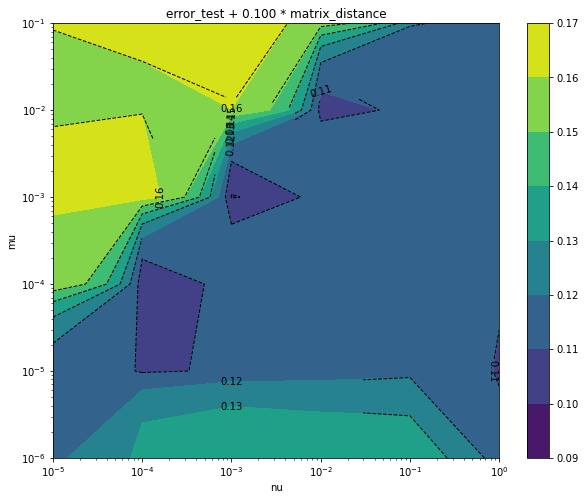

In [29]:
fig = plt.figure(figsize=(10, 8))
p = 0.1
cp = plt.contour(X1, X2, Z_test + p * Z_dist, colors='black', linestyles='dashed', linewidths=1)
plt.clabel(cp, inline=1, fontsize=10)
cp = plt.contourf(X1, X2, Z_test + p * Z_dist, )
cbar = fig.colorbar(cp)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('nu')
plt.ylabel('mu')
plt.title('error_test + {:.3f} * matrix_distance'.format(p))
plt.show()

## Tensorboard

In [30]:
%reload_ext tensorboard
%tensorboard --logdir=gl_common_logs/